TODO:
1. Test if having linear activation for output layer on the deceptor will cause it to "cheat"
2. Test different activation functions for output layer on the deceptor

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [15]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images, test_images = train_images / 256, test_images / 256
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [13]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(10, activation="relu")
])
classifier.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [4]:
image_deceptor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(28, input_shape=(28, 28), activation="linear")
])
#deceptor.compile()
image_deceptor.build((28, 28))
print(image_deceptor.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (28, 128)                 3712      
                                                                 
 dense_3 (Dense)             (28, 128)                 16512     
                                                                 
 dense_4 (Dense)             (28, 28)                  3612      
                                                                 
Total params: 23,836
Trainable params: 23,836
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
label_deceptor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(10,)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(784, activation="linear"),
    tf.keras.layers.Reshape((28, 28))
])
label_deceptor.compile()
#label_deceptor.build([10])

In [ ]:
plt.imshow(label_deceptor([np.arange(10),])[0])

In [8]:
classifier_optimizer = tf.keras.optimizers.Adam(1e-6)
deceptor_optimizer = tf.keras.optimizers.Adam(1e-6)
classifier_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


def deceptor_loss(original_loss, modified_loss):
    return tf.math.exp(original_loss - modified_loss)

In [9]:
class ModelPair:
    def __init__(self, classifier, deceptor):
        self.classifier=classifier
        self.deceptor=deceptor
    
    
    @tf.function
    def train_step(self, images, labels, noise_weight=0.1):
        start_time=time.perf_counter()
        base = tf.zeros(10)
        print(type(labels))
        with tf.GradientTape() as cls_tape, tf.GradientTape() as dcp_tape:
            cls_tape.watch(self.classifier.variables)
            dcp_tape.watch(self.deceptor.variables)
            #Real Prediction
            real_prediction = self.classifier(tf.expand_dims(images, 0), training=True)

            #Fake Prediction
            noise_profile = tf.cast(self.deceptor(labels, training=True), dtype=tf.float64)
            images = tf.math.add(tf.convert_to_tensor(images) * (1-noise_weight), noise_profile * noise_weight)
            images.set_shape((28, 28))
            fake_prediction = self.classifier(tf.expand_dims(images, 0), training=True)

            #Calculae Loss
            real_loss = classifier_loss(labels, real_prediction)
            fake_loss = classifier_loss(labels, fake_prediction)
            dcp_loss = deceptor_loss(fake_loss, real_loss)
            
            
        #Calculate Gradients
        gradients_of_classifier = cls_tape.gradient(fake_loss, self.classifier.trainable_variables)
        gradients_of_deceptor = dcp_tape.gradient(dcp_loss, self.deceptor.trainable_variables)

        #Apply Gradients
        classifier_optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))
        deceptor_optimizer.apply_gradients(zip(gradients_of_deceptor, self.deceptor.trainable_variables))
        end_time = time.perf_counter()
        total_time = end_time-start_time
#        print(f"Step time: {total_time} Classifier loss: {fake_loss} Deceptor loss: {dcp_loss}", end="\r")
        return [fake_loss, dcp_loss]
    
    
    def train(self, images, labels, epochs, noise_weight=0.1):
        assert noise_weight <= 1.0
        losses = []
        for epoch in range(epochs):
            for i, (image_batch, label_batch) in enumerate(zip(images, labels)):
                print(f"Image: {i}", end="\r")
                step_loss = self.train_step(image_batch, label_batch)
                losses.append(step_loss)
            print(f"Finished epoch {epoch}")
        losses = np.asarray(losses)
        return np.transpose(losses)

In [10]:
models = ModelPair(classifier, label_deceptor)
#history = models.train(train_images[:500], train_labels[:500], 1, noise_weight=0.1)
#plt.plot(history[0])

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(1e-6)
deceptor_optimizer = tf.keras.optimizers.Adam(1e-6)
classifier_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# def deceptor_loss(classifierLoss):
#     return 1/classifierLoss


def deceptor_loss(original_loss, modified_loss):
    #return 1/(modified_loss - original_loss)
    return tf.math.exp(original_loss - modified_loss)

@tf.function
def train_step(images, labels, noise_weight=0.1):
#    print(labels)
    start_time=time.perf_counter()
    with tf.GradientTape() as cls_tape, tf.GradientTape() as dcp_tape:
        cls_tape.watch(classifier.variables)
        dcp_tape.watch(deceptor.variables)
        #Real Prediction
        real_prediction = classifier(tf.expand_dims(images, 0), training=True)
        
        #Fake Prediction
        noise_profile = tf.cast(deceptor(images, training=True), dtype=tf.float64)
        images = tf.math.add(tf.convert_to_tensor(images) * (1-noise_weight), noise_profile * noise_weight)
        images.set_shape((28, 28))
        fake_prediction = classifier(tf.expand_dims(images, 0), training=True)

        #Calculae Loss
        real_loss = classifier_loss(labels, real_prediction)
        fake_loss = classifier_loss(labels, fake_prediction)
        dcp_loss = deceptor_loss(fake_loss, real_loss)
        if real_loss < 0:
            print(real_loss)
        if real_loss < 0:
            print(real_loss)

    #Calculate Gradients
    gradients_of_classifier = cls_tape.gradient(fake_loss, classifier.trainable_variables)
    gradients_of_deceptor = dcp_tape.gradient(dcp_loss, deceptor.trainable_variables)
    
    #Apply Gradients
    classifier_optimizer.apply_gradients(zip(gradients_of_classifier, classifier.trainable_variables))
    deceptor_optimizer.apply_gradients(zip(gradients_of_deceptor, deceptor.trainable_variables))
    end_time = time.perf_counter()
    total_time = end_time-start_time
    print(f"Step time: {total_time} Classifier loss: {fake_loss} Deceptor loss: {dcp_loss}", end="\r")
    return [fake_loss, dcp_loss]
def train(images, labels, epochs, noise_weight=0.1):
    assert noise_weight <= 1.0
    losses = []
    for epoch in range(epochs):
        for i, (image_batch, label_batch) in enumerate(zip(images, labels)):
            print(f"Image: {i}", end="\r")
            step_loss = train_step(image_batch, label_batch)
            losses.append(step_loss)
        print(f"Finished epoch {epoch}")
    losses = np.asarray(losses)
    return np.transpose(losses)

In [ ]:
history = train(train_images, train_labels, 1, noise_weight=0.1)

In [ ]:
history2 = classifier.fit(train_images, train_labels, epochs=20, batch_size=60000)

In [ ]:
mpl.pyplot.plot(history[0])
mpl.pyplot.plot(history[1])

In [ ]:
mpl.pyplot.plot(history2.history['loss'])

In [ ]:
plt.imshow(deceptor(train_images[3]))

In [ ]:
classifier.evaluate(test_images, test_labels)

Cringe:0.6588305830955505

In [61]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [14]:
classifier.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6135
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4566
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4406
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4264
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4231


T-shirt/top: [ 0.        0.        0.        0.        0.       34.83676   0.
 30.724604 10.820193 38.276157]


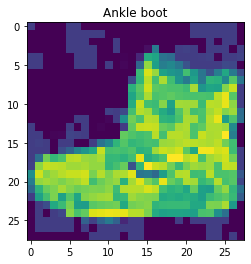

In [81]:
index = 0
image = example_image
plt.figure()
predictions = classifier(np.expand_dims(image, 0)).numpy()
prediction = np.argmax(predictions)
format_predictions(predictions, label_names)
plt.title(label_names[prediction])
plt.imshow(image)

In [70]:
def generate_example(image, label):
    image = tf.convert_to_tensor(image)
    label_logits = np.zeros(10)
    label_logits[label] = 1.0
    label_logits = tf.convert_to_tensor(label_logits)
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = classifier(tf.expand_dims(image, 0))
        loss = loss_function(predictions[0], label_logits)
    gradient = tape.gradient(loss, image)
    signed_gradient = tf.sign(gradient)
    return signed_gradient

In [79]:
def format_predictions(numbers, labels):
    for number, label in zip(numbers, labels):
        print(f"{label}: {number}")

In [ ]:
example = generate_example(train_images[0], train_labels[0])

In [74]:
example_image = train_images[0] * 0.9 + example.numpy() * 0.1